## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/cotra_2022')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 25.6,
 5: 27.1,
 10: 27.9,
 20: 29.6,
 30: 31.3,
 40: 32.7,
 50: 34.1,
 60: 35.6,
 70: 37.2,
 80: 39.1,
 90: 41.8,
 95: 44.6,
 99: 60.103000000000065}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.5,
 5: 7.7,
 10: 7.9,
 20: 8.0,
 30: 8.1,
 40: 8.3,
 50: 8.4,
 60: 8.5,
 70: 8.6,
 80: 8.8,
 90: 9.1,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.39, sd=0.42)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.15 weight on <Distribution> lognorm(mean=2.33, sd=0.23)},
 'integration': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.25, sd=0.7)},
 'real_world_feedback': {'prob': 

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 465124.20it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.000306643201527754,
 50: 0.0003825455825134679,
 60: 0.0004994555580557021,
 70: 0.0006788421357941562,
 80: 0.001024215425050495,
 90: 0.0021878520045390125,
 95: 0.00412779713223418,
 99: 0.009825953641823704}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.1e+09',
 50: '8.8e+09',
 60: '1.1e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '5.0e+10',
 95: '9.5e+10',
 99: '2.3e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (697 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (422 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
Ye

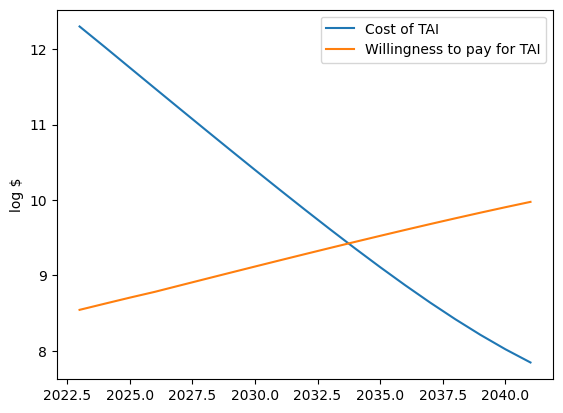

-
-
## SAMPLE RUN 2 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~488 quintillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.6 max log FLOP (371 septillion) available - TAI takes 32.8 log FLOP (631 nonillion) - log $ 14.5 to buy TAI (318 trillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (624 septillion) available - TAI takes 32.7 log FLOP (452 nonillion) - log $ 14.3 to buy TAI (183 trillion) vs. willingness to pay log $ 8.4 (253 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-l

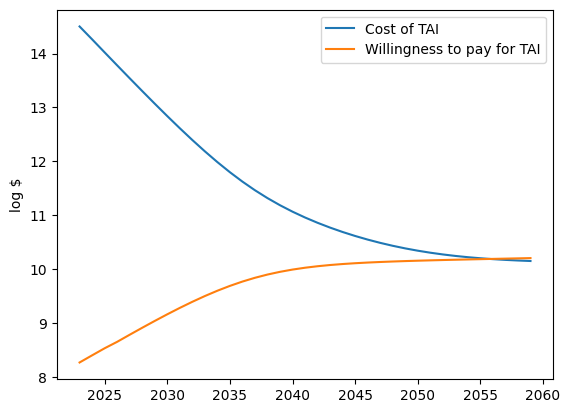

-
-
## SAMPLE RUN 3 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~218 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 3.0 years to a max of 0.088976% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.3 max log FLOP (198 septillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (316 quintillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (326 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.1 to buy TAI (120 quintillion) vs. willingness to pay log $ 8.1 (124 million) - 18.4 log FLOP per $ (

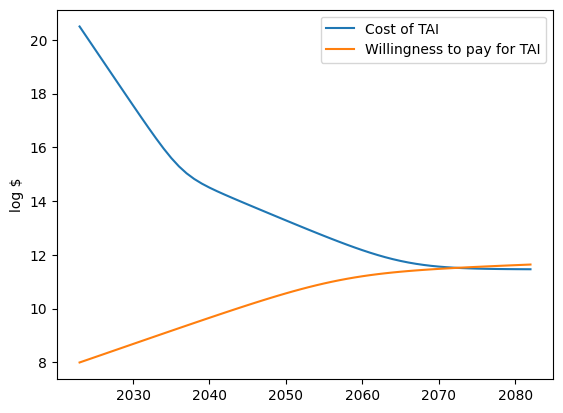

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 210.50it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.84it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2033',
 '10%: 2036',
 '15%: 2038',
 '20%: 2040',
 '25%: 2042',
 '35%: 2047',
 '50%: 2057',
 '60%: 2079',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 10 years from now',
 '10%: 13 years from now',
 '15%: 15 years from now',
 '20%: 17 years from now',
 '25%: 19 years from now',
 '35%: 24 years from now',
 '50%: 34 years from now',
 '60%: 56 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 0.6%
2030-2034: 6.5%
2035-2039: 11.3%
2040-2049: 20.4%
2050-2059: 12.8%
2060-2069: 5.4%
2070-2079: 2.9%
2080-2089: 1.7%
2090-2099: 1.2%
2100-2109: 1.0%
2110-2119: 0.6%
>2120: 35.5%
-

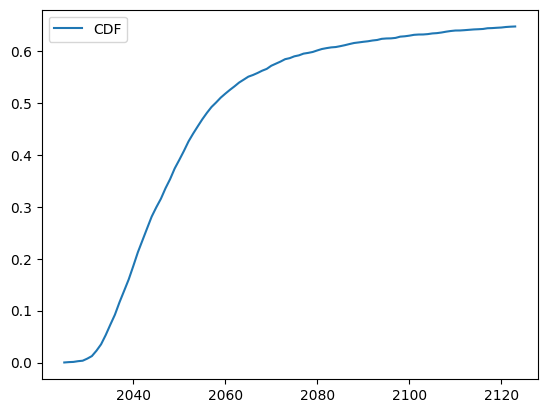

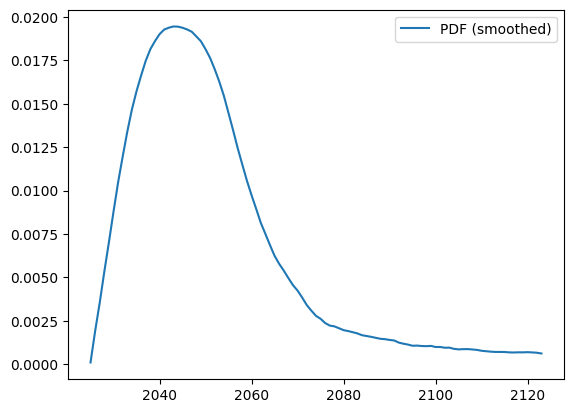

-
-
## TAI FLOP SIZE ##
{1: 25.8,
 5: 27.1,
 10: 27.9,
 20: 29.6,
 30: 31.2,
 40: 32.6,
 50: 34.0,
 60: 35.6,
 70: 37.1,
 80: 38.8,
 90: 41.5,
 95: 44.1,
 99: 52.8}


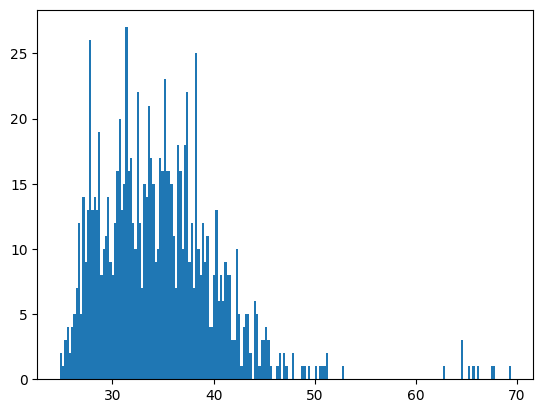

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 18.8,
 5: 14.4,
 10: 12.0,
 20: 9.7,
 30: 8.5,
 40: 7.4,
 50: 6.6,
 60: 5.8,
 70: 5.1,
 80: 4.4,
 90: 3.5,
 95: 3.0,
 99: 2.1}


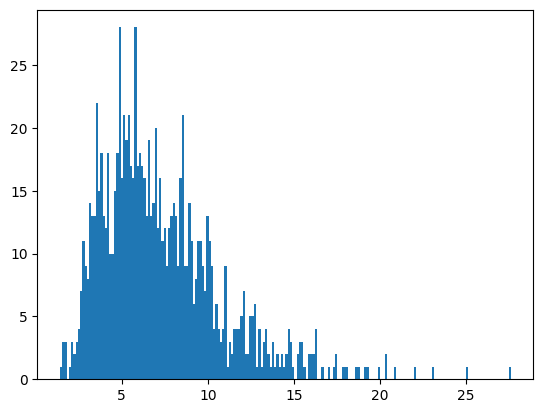

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.8,
 40: 2.6,
 50: 2.5,
 60: 2.3,
 70: 2.1,
 80: 2.0,
 90: 1.7,
 95: 1.5,
 99: 1.1}


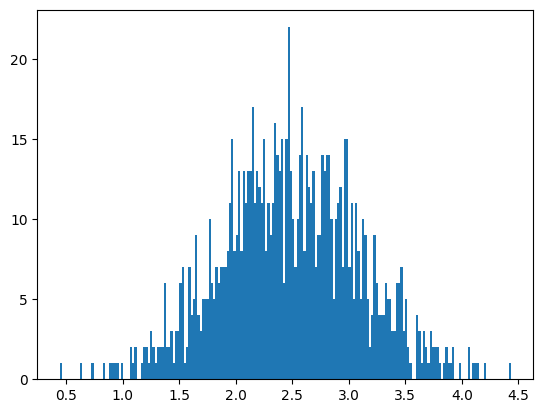

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.6,
 5: 21.0,
 10: 21.2,
 20: 21.5,
 30: 21.7,
 40: 21.8,
 50: 22.0,
 60: 22.2,
 70: 22.3,
 80: 22.5,
 90: 22.8,
 95: 23.0,
 99: 23.4}


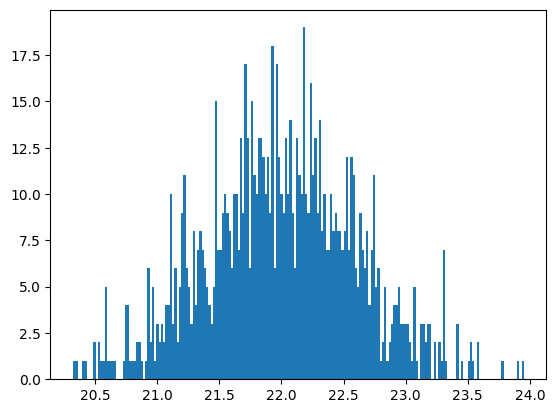

-
-
## INITIAL PAY ##
{1: 7.5,
 5: 7.7,
 10: 7.9,
 20: 8.0,
 30: 8.2,
 40: 8.3,
 50: 8.4,
 60: 8.5,
 70: 8.6,
 80: 8.8,
 90: 9.0,
 95: 9.3,
 99: 9.8}


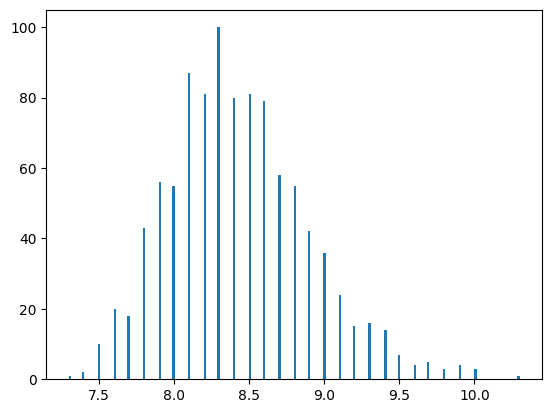

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


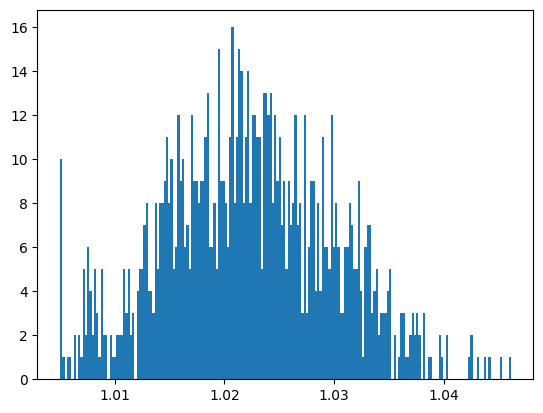

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00028,
 50: 0.00036,
 60: 0.00049,
 70: 0.00065,
 80: 0.00099,
 90: 0.00214,
 95: 0.00349,
 99: 0.00727}


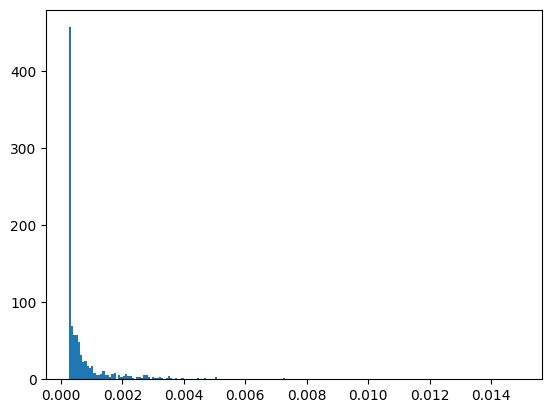

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.2,
 20: 3.8,
 30: 3.5,
 40: 3.2,
 50: 3.0,
 60: 2.8,
 70: 2.5,
 80: 2.3,
 90: 1.8,
 95: 1.5,
 99: 1.0}


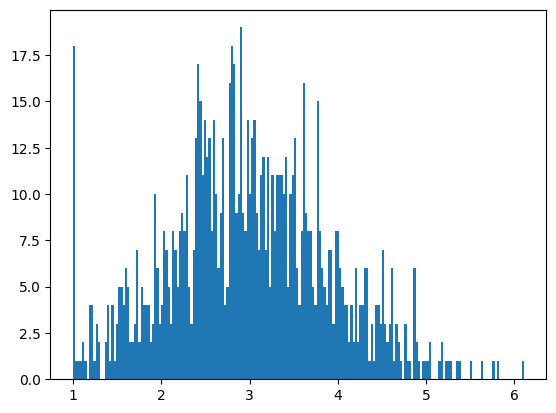

-
-
-
-
## GDP Over Time ##


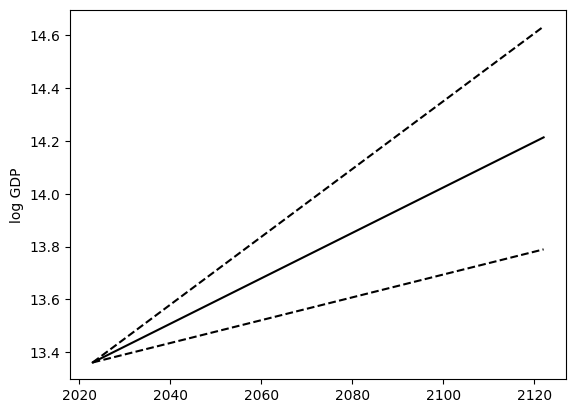

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

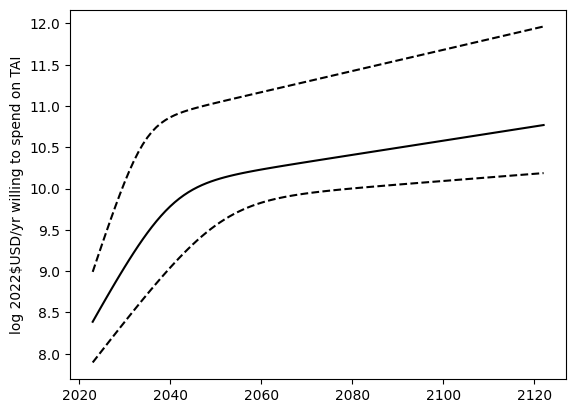

Year: 2023 - willingness log 2022$USD per year 8.4 (~244 million) 90% CI 7.9 (~78 million) - 9.0 (~980 million)
Year: 2024 - willingness log 2022$USD per year 8.5 (~305 million) 90% CI 8.0 (~92 million) - 9.2 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.6 (~381 million) 90% CI 8.0 (~108 million) - 9.3 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.7 (~475 million) 90% CI 8.1 (~128 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.8 (~591 million) 90% CI 8.2 (~150 million) - 9.6 (~4 billion)
Year: 2028 - willingness log 2022$USD per year 8.9 (~733 million) 90% CI 8.2 (~176 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 9.0 (~907 million) 90% CI 8.3 (~207 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 9.0 (~1 billion) 90% CI 8.4 (~242 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~284 million) - 10.2 (~16 billion)
Y

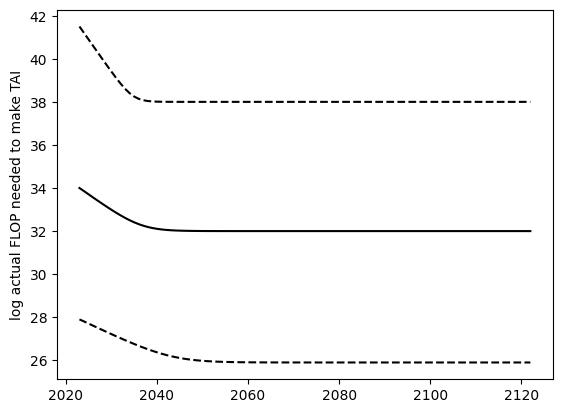

Year: 2023 - log FLOP needed for TAI 34.0 (~10 decillion) 90% CI 27.9 (~8 octillion) - 41.5 (~316 million decillion)
Year: 2024 - log FLOP needed for TAI 33.9 (~7 decillion) 90% CI 27.8 (~6 octillion) - 41.2 (~158 million decillion)
Year: 2025 - log FLOP needed for TAI 33.7 (~5 decillion) 90% CI 27.7 (~5 octillion) - 40.9 (~79 million decillion)
Year: 2026 - log FLOP needed for TAI 33.6 (~4 decillion) 90% CI 27.6 (~4 octillion) - 40.6 (~40 million decillion)
Year: 2027 - log FLOP needed for TAI 33.4 (~3 decillion) 90% CI 27.5 (~3 octillion) - 40.3 (~20 million decillion)
Year: 2028 - log FLOP needed for TAI 33.3 (~2 decillion) 90% CI 27.4 (~3 octillion) - 40.0 (~10 million decillion)
Year: 2029 - log FLOP needed for TAI 33.1 (~1 decillion) 90% CI 27.3 (~2 octillion) - 39.7 (~5 million decillion)
Year: 2030 - log FLOP needed for TAI 33.0 (~984 nonillion) 90% CI 27.2 (~2 octillion) - 39.4 (~3 million decillion)
Year: 2031 - log FLOP needed for TAI 32.9 (~725 nonillion) 90% CI 27.1 (~1 oc

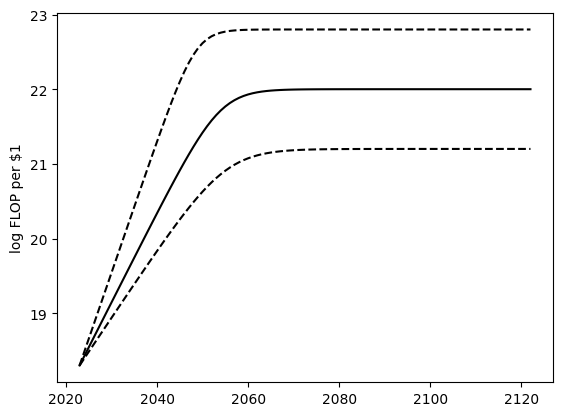

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.7 (~52 quint

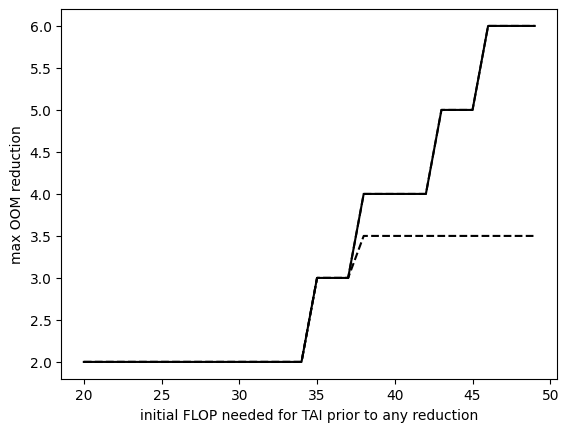

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

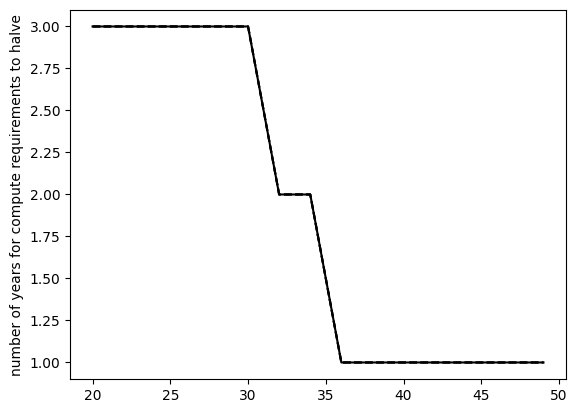

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

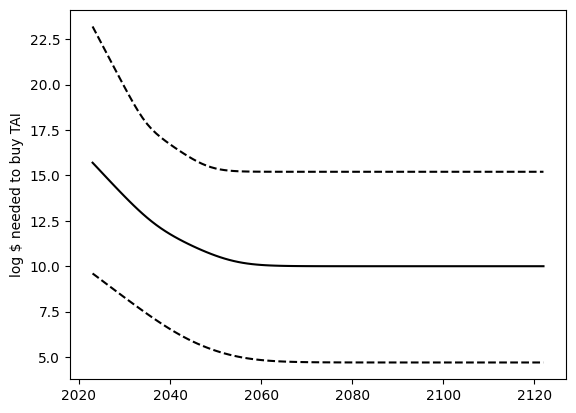

Year: 2023 - 15.7 log 2022$USD to buy TAI (~5 quadrillion) 90% CI 9.6 (~4 billion) - 23.2 (~158 sextillion)
Year: 2024 - 15.4 log 2022$USD to buy TAI (~3 quadrillion) 90% CI 9.4 (~3 billion) - 22.7 (~53 sextillion)
Year: 2025 - 15.2 log 2022$USD to buy TAI (~1 quadrillion) 90% CI 9.2 (~2 billion) - 22.2 (~18 sextillion)
Year: 2026 - 14.9 log 2022$USD to buy TAI (~793 trillion) 90% CI 9.0 (~1 billion) - 21.8 (~6 sextillion)
Year: 2027 - 14.6 log 2022$USD to buy TAI (~430 trillion) 90% CI 8.8 (~701 million) - 21.3 (~2 sextillion)
Year: 2028 - 14.4 log 2022$USD to buy TAI (~234 trillion) 90% CI 8.7 (~454 million) - 20.8 (~652 quintillion)
Year: 2029 - 14.1 log 2022$USD to buy TAI (~128 trillion) 90% CI 8.5 (~295 million) - 20.3 (~219 quintillion)
Year: 2030 - 13.9 log 2022$USD to buy TAI (~71 trillion) 90% CI 8.3 (~192 million) - 19.9 (~74 quintillion)
Year: 2031 - 13.6 log 2022$USD to buy TAI (~40 trillion) 90% CI 8.1 (~125 million) - 19.4 (~26 quintillion)
Year: 2032 - 13.4 log 2022$USD

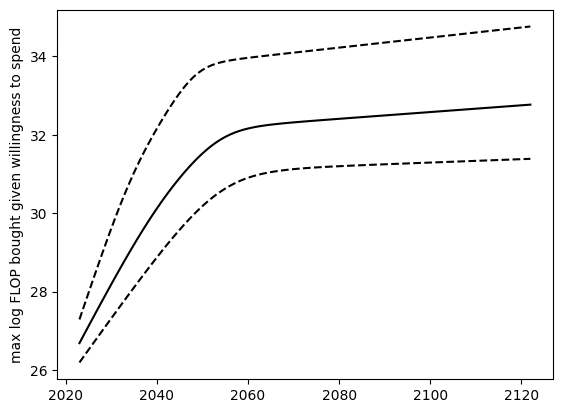

Year: 2023 - max log FLOP 26.7 (~486 septillion) 90% CI 26.2 (~156 septillion) - 27.3 (~2 octillion)
Year: 2024 - max log FLOP 26.9 (~803 septillion) 90% CI 26.4 (~227 septillion) - 27.6 (~4 octillion)
Year: 2025 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~329 septillion) - 28.0 (~9 octillion)
Year: 2026 - max log FLOP 27.3 (~2 octillion) 90% CI 26.7 (~477 septillion) - 28.3 (~20 octillion)
Year: 2027 - max log FLOP 27.6 (~4 octillion) 90% CI 26.8 (~691 septillion) - 28.6 (~44 octillion)
Year: 2028 - max log FLOP 27.8 (~6 octillion) 90% CI 27.0 (~1 octillion) - 29.0 (~94 octillion)
Year: 2029 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~1 octillion) - 29.3 (~198 octillion)
Year: 2030 - max log FLOP 28.2 (~16 octillion) 90% CI 27.3 (~2 octillion) - 29.6 (~412 octillion)
Year: 2031 - max log FLOP 28.4 (~25 octillion) 90% CI 27.5 (~3 octillion) - 29.9 (~840 octillion)
Year: 2032 - max log FLOP 28.6 (~40 octillion) 90% CI 27.6 (~4 octillion) - 30.2 (~2 nonillion)
Year: 2033 - max

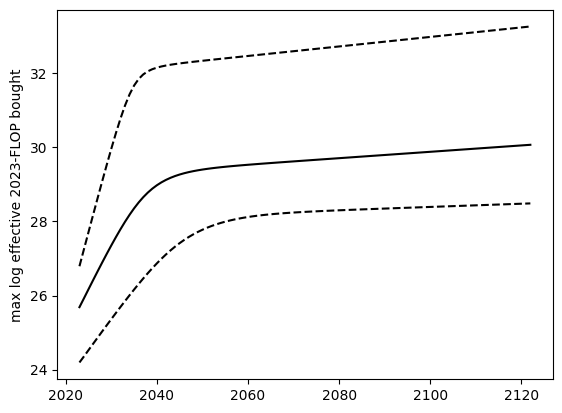

Year: 2023 - max log FLOP 25.7 (~49 septillion) 90% CI 24.2 (~2 septillion) - 26.8 (~618 septillion)
Year: 2024 - max log FLOP 25.9 (~85 septillion) 90% CI 24.4 (~2 septillion) - 27.3 (~2 octillion)
Year: 2025 - max log FLOP 26.2 (~149 septillion) 90% CI 24.5 (~3 septillion) - 27.7 (~5 octillion)
Year: 2026 - max log FLOP 26.4 (~261 septillion) 90% CI 24.7 (~5 septillion) - 28.2 (~15 octillion)
Year: 2027 - max log FLOP 26.7 (~454 septillion) 90% CI 24.9 (~7 septillion) - 28.6 (~43 octillion)
Year: 2028 - max log FLOP 26.9 (~784 septillion) 90% CI 25.0 (~11 septillion) - 29.1 (~122 octillion)
Year: 2029 - max log FLOP 27.1 (~1 octillion) 90% CI 25.2 (~16 septillion) - 29.5 (~341 octillion)
Year: 2030 - max log FLOP 27.4 (~2 octillion) 90% CI 25.4 (~23 septillion) - 30.0 (~924 octillion)
Year: 2031 - max log FLOP 27.6 (~4 octillion) 90% CI 25.5 (~34 septillion) - 30.4 (~2 nonillion)
Year: 2032 - max log FLOP 27.8 (~6 octillion) 90% CI 25.7 (~49 septillion) - 30.8 (~6 nonillion)
Year: 20

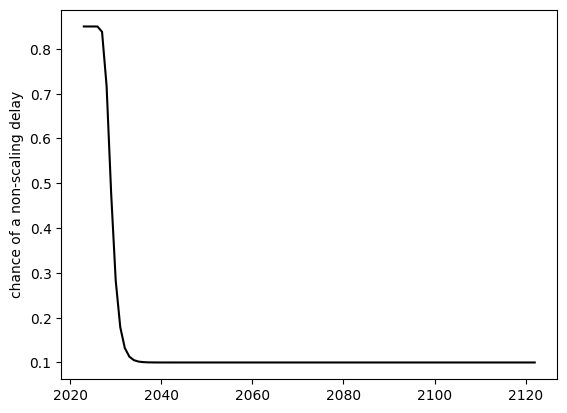

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 72%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

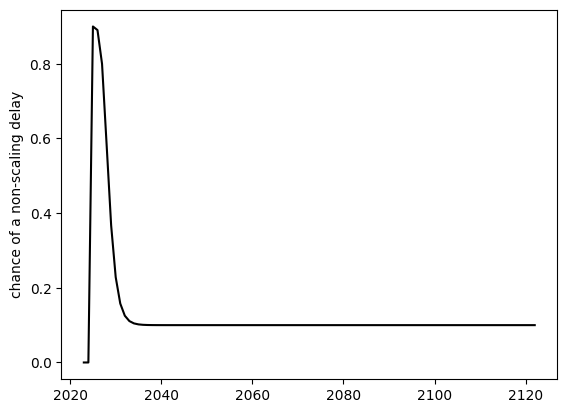

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033 -

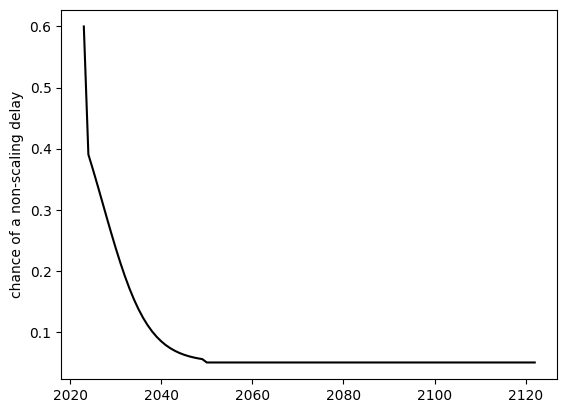

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

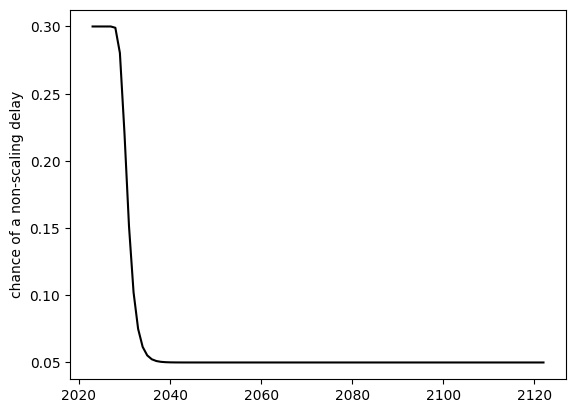

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

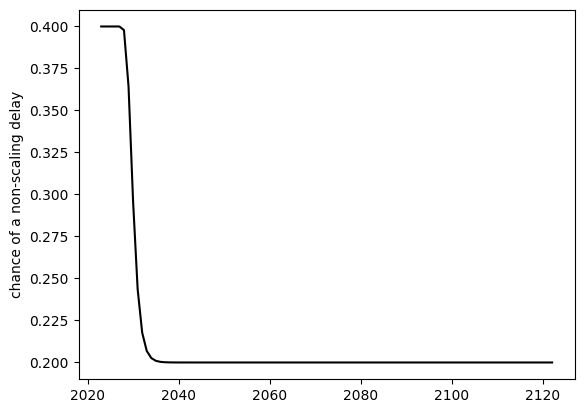

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 36%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2033

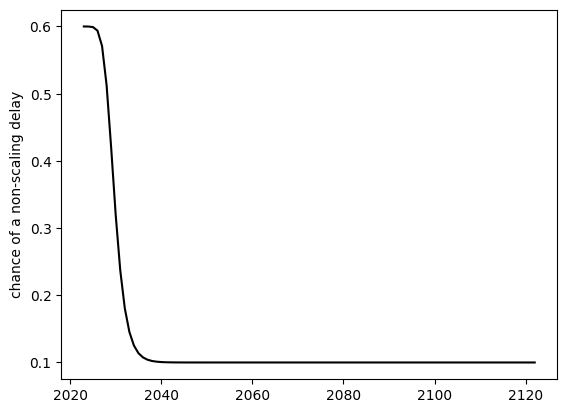

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033

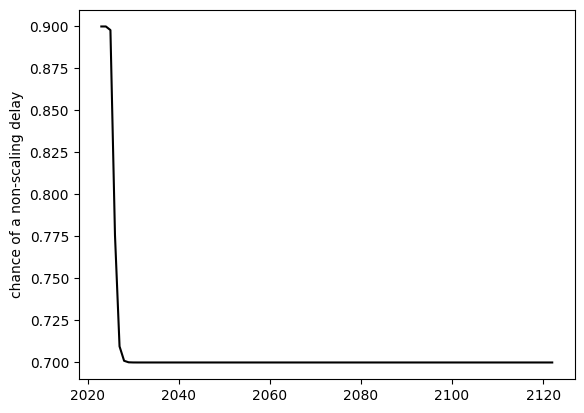

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 78%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2033

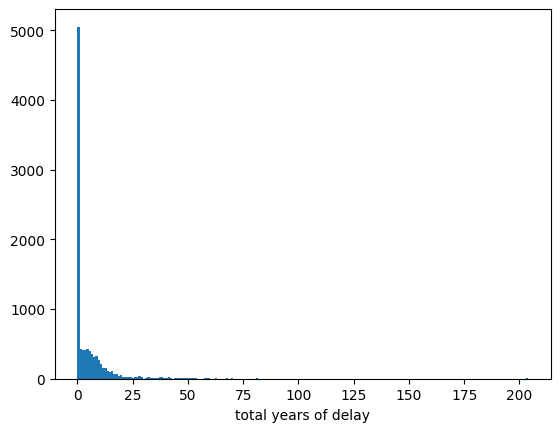

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 61.5 log FLOP (~32 octillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 7.7 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 3.9 years to a max of 0.037462% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.5 max log FLOP (305 septillion) available - TAI takes 61.5 log FLOP (32 octillion decillion) - log $ 43.2 to buy TAI (16 billion decillion) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (452 septillion) available - TAI takes 61.2 log FLOP (16 octillion decillion) - log $ 42.8 to buy TAI (6 billion decillion) vs. willingness to pay log $ 8.3 (182 million) - 18.4 log F

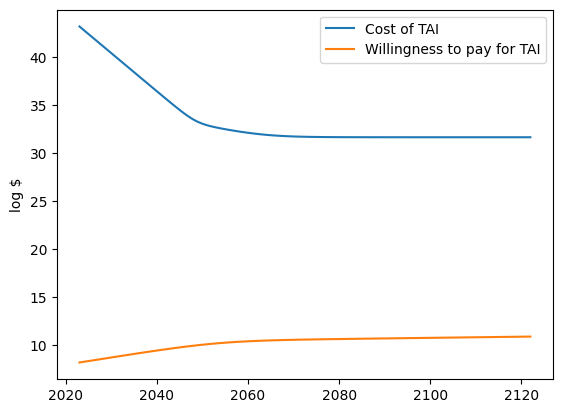

-
-
## SAMPLE RUN 5 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~49 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~2 billion). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.8)
-- algorithms p_

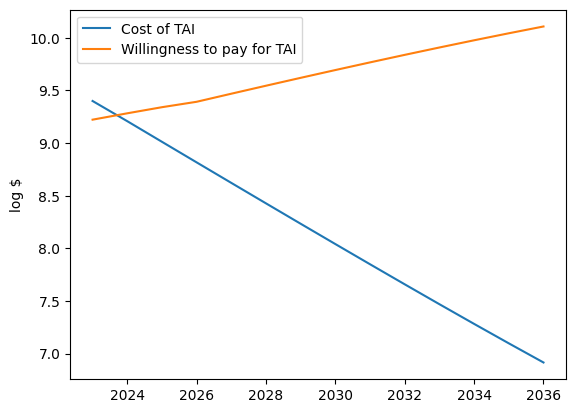

-
-
## SAMPLE RUN 6 ##
It takes 35.3 log FLOP (~200 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 17.0 to buy TAI (100 quadrillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (607 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.7 to buy TAI (48 quadrillion) vs. willingness to pay log $ 8.4 (232 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023

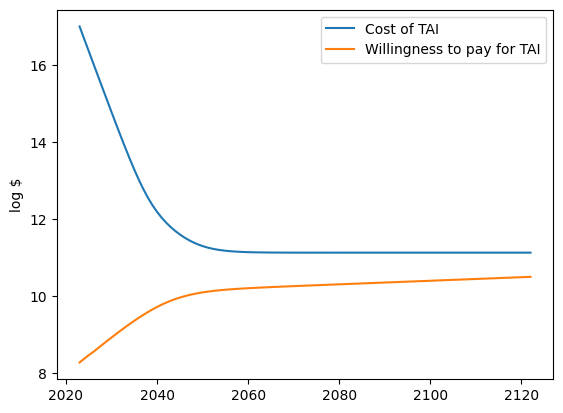

-
-
## SAMPLE RUN 7 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 4.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (291 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 8.0 (112 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.6

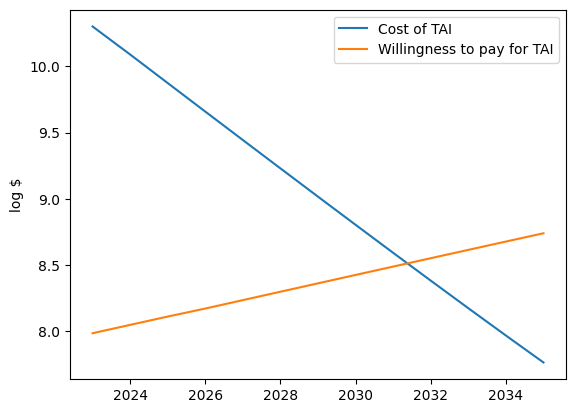

-
-
## SAMPLE RUN 8 ##
It takes 32.9 log FLOP (~794 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~948 quintillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 1.0 years until 2025, and then doubles every 1 years to a max of 0.070924% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 32.9 log FLOP (794 nonillion) - log $ 14.6 to buy TAI (399 trillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.7 max log FLOP (514 septillion) available - TAI takes 32.8 log FLOP (570 nonillion) - log $ 14.3 to buy TAI (215 trillion) vs. willingness to pay log $ 8.3 (194 million) - 18.4 log 

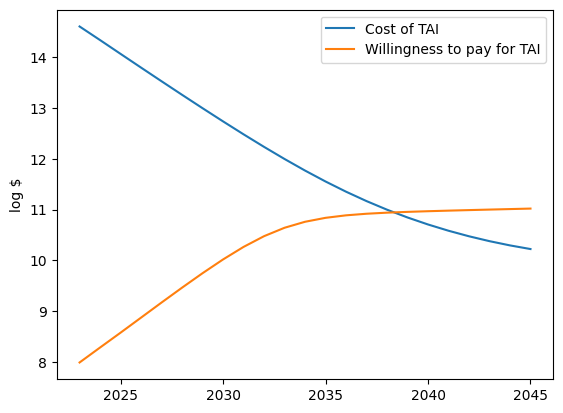

-
-
## SAMPLE RUN 9 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 2.1 years to a max of 0.075392% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 31.7 log FLOP (50 nonillion) - log $ 13.4 to buy TAI (25 trillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 25.9)
Year: 2024 - 26.2 max log FLOP (168 septillion) available - TAI takes 31.6 log FLOP (38 nonillion) - log $ 13.1 to buy TAI (13 trillion) vs. willingness to pay log $ 7.7 (55 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

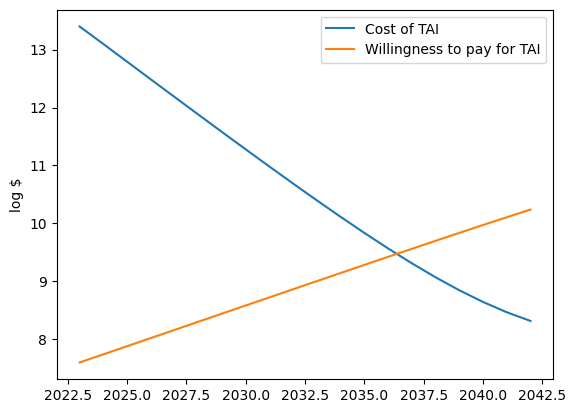

-
-
## SAMPLE RUN 10 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 3.7 years to a max of 0.099494% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (391 septillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 8.3 (196 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.6 -> Nonscaling delay 

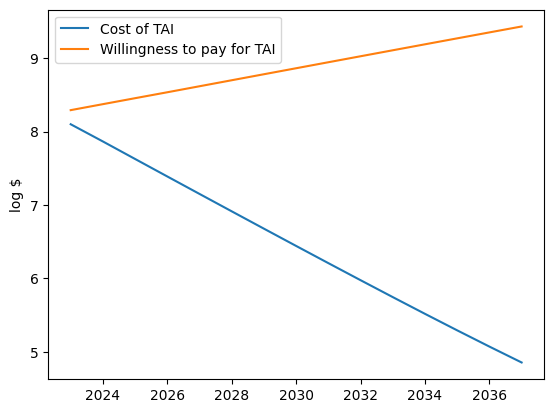

-
-
## SAMPLE RUN 11 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 2.9 years to a max of 0.029533% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.6 max log FLOP (376 septillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.4 to buy TAI (251 trillion) vs. willingness to pay log $ 8.3 (188 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (637 septillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.1 to buy TAI (135 trillion) vs. willingness to pay log $ 8.4 (238 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-

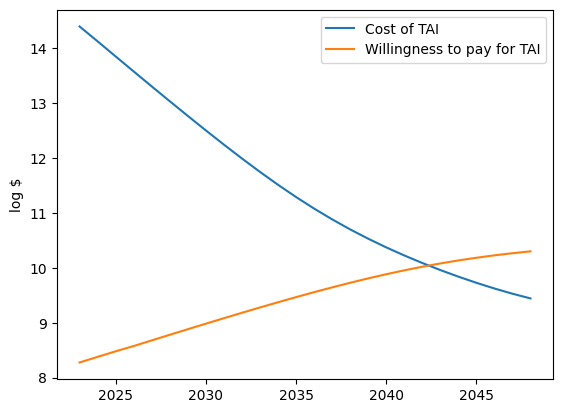

-
-
## SAMPLE RUN 12 ##
It takes 32.3 log FLOP (~200 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.0 years to a max of 0.047429% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.3 max log FLOP (196 septillion) available - TAI takes 32.3 log FLOP (200 nonillion) - log $ 14.0 to buy TAI (100 trillion) vs. willingness to pay log $ 8.0 (98 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.6 max log FLOP (372 septillion) available - TAI takes 32.2 log FLOP (143 nonillion) - log $ 13.7 to buy TAI (53 trillion) vs. willingness to pay log $ 8.1 (137 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-lo

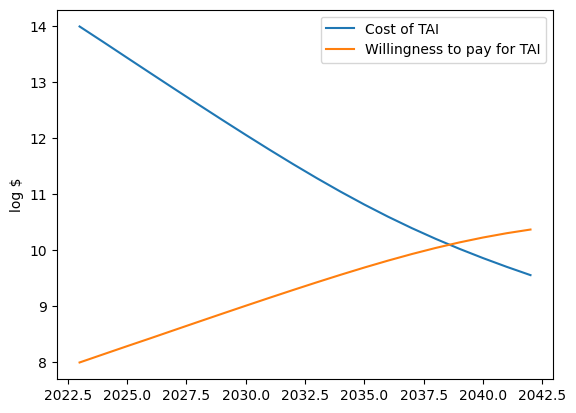

-
-
## SAMPLE RUN 13 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 2.3 years to a max of 0.041103% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (795 trillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.0)
Year: 2024 - 26.2 max log FLOP (172 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (440 trillion) vs. willingness to pay log $ 7.8 (67 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

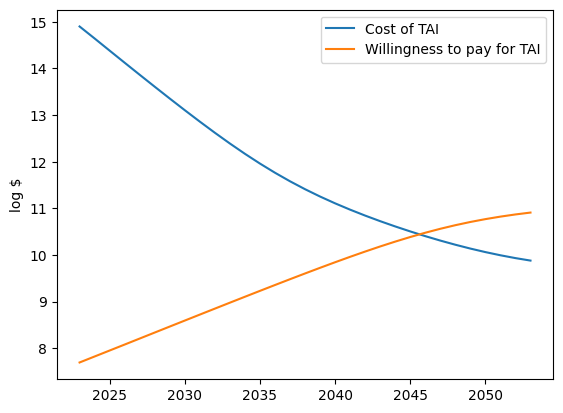

-
-
## SAMPLE RUN 14 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 5.0 years to a max of 0.050193% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.7 max log FLOP (480 septillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.4 (241 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (763 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.4 (276 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

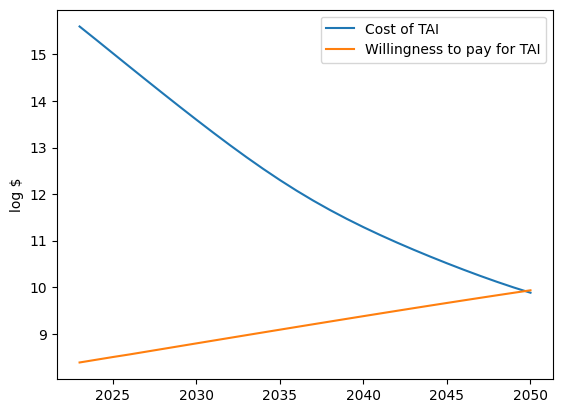

-
-
## SAMPLE RUN 15 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~34 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (373 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7

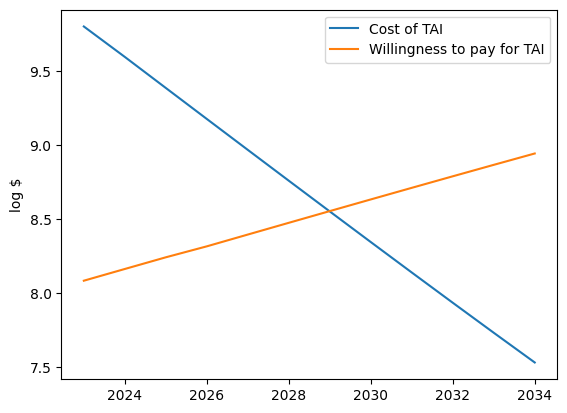

-
-
## SAMPLE RUN 16 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 1.7 years to a max of 0.300998% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.0 max log FLOP (100 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.0)
Year: 2024 - 26.3 max log FLOP (200 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 7.9 (75 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.4)
Yea

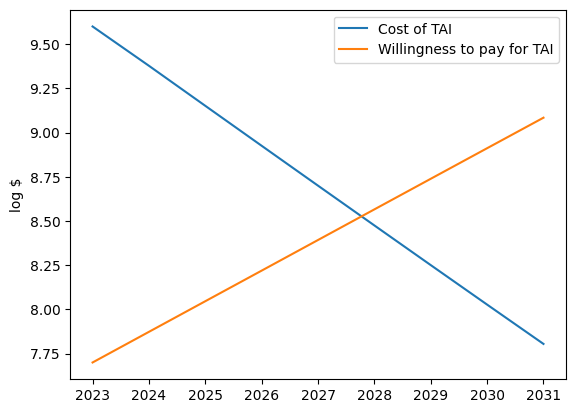

-
-
## SAMPLE RUN 17 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~113 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~392 million). This doubles every 3.9 years to a max of 0.119161% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.9 max log FLOP (772 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.6 (387 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (744 million) vs. willingness to pay log $ 8.7 (460 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)


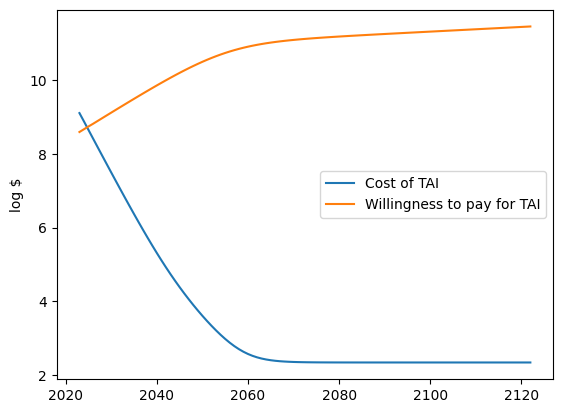

-
-
## SAMPLE RUN 18 ##
It takes 34.5 log FLOP (~32 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 4.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 16.2 to buy TAI (16 quadrillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (372 septillion) available - TAI takes 34.3 log FLOP (20 decillion) - log $ 15.9 to buy TAI (8 quadrillion) vs. willingness to pay log $ 8.1 (140 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

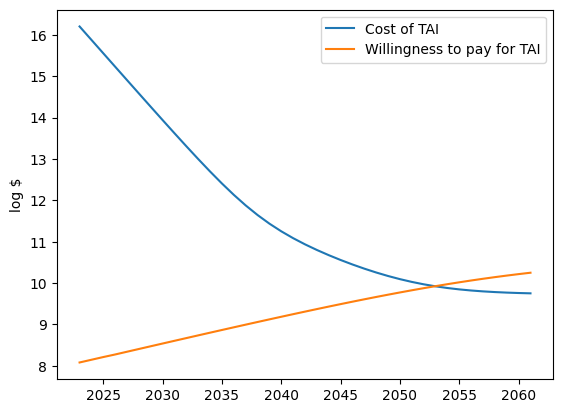

-
-
## SAMPLE RUN 19 ##
It takes 34.7 log FLOP (~50 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~320 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 4.5 years to a max of 0.10998% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.4 max log FLOP (249 septillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.4 to buy TAI (25 quadrillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (395 septillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 16.1 to buy TAI (12 quadrillion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 202

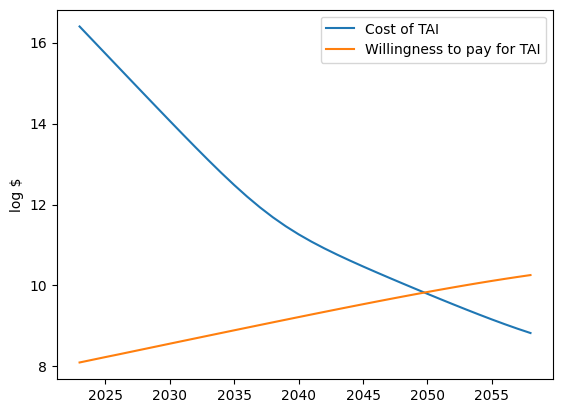

-
-
## SAMPLE RUN 20 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.7 to buy TAI (501 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.4 to buy TAI (271 million) vs. willingness to pay log $ 8.8 (594 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
-

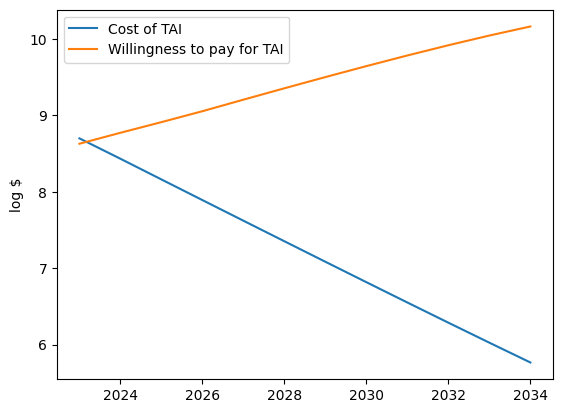

-
-
## SAMPLE RUN 21 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 3.6 years to a max of 0.076019% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 7.5 (32 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 25.8)
Year: 2024 - 26.0 max log FLOP (107 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (9 quadrillion) vs. willingness to pay log $ 7.6 (38 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

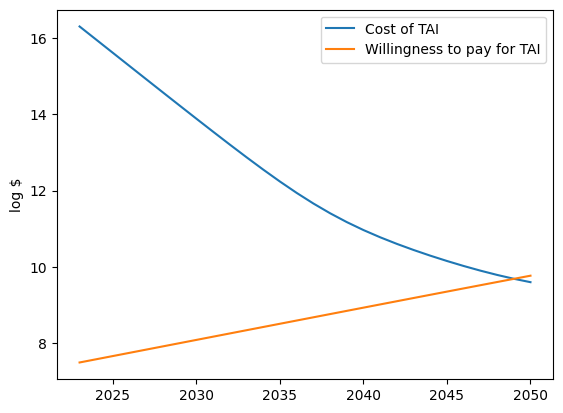

-
-
## SAMPLE RUN 22 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.4 years to a max of 0.107236% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP (288 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.0 to buy TAI (11 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26

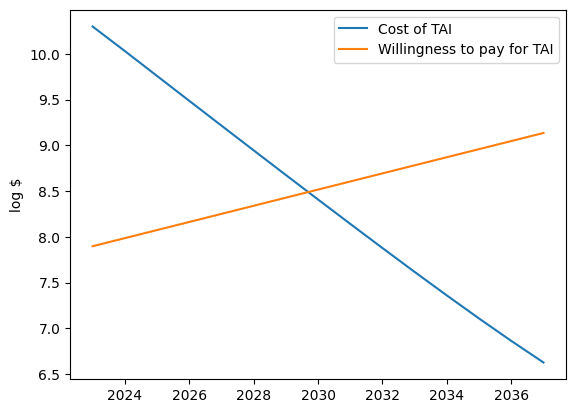

-
-
## SAMPLE RUN 23 ##
It takes 34.4 log FLOP (~25 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~60 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 2.3 years to a max of 0.066528% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.5 max log FLOP (310 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.1 to buy TAI (13 quadrillion) vs. willingness to pay log $ 8.2 (155 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.8 max log FLOP (608 septillion) available - TAI takes 34.2 log FLOP (16 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 8.3 (210 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023

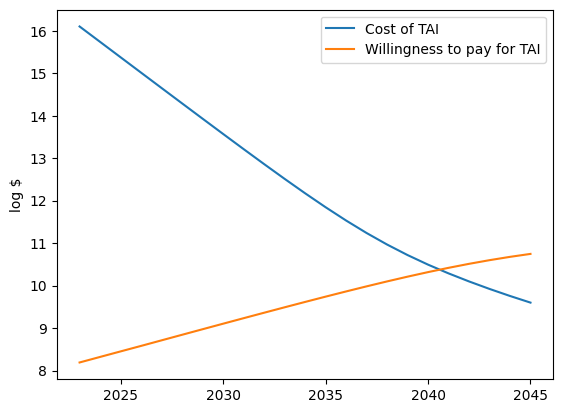

-
-
## SAMPLE RUN 24 ##
It takes 42.2 log FLOP (~2 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~39 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 3.9 years to a max of 0.307806% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (625 septillion) available - TAI takes 42.2 log FLOP (2 billion decillion) - log $ 23.9 to buy TAI (794 sextillion) vs. willingness to pay log $ 8.5 (313 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 41.9 log FLOP (793 million decillion) - log $ 23.5 to buy TAI (293 sextillion) vs. willingness to pay log $ 8.6 (375 million) - 18.4 log FLOP per $ (3 quintil

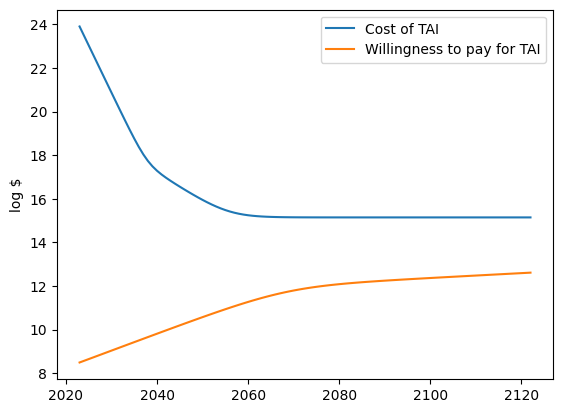

-
-
## SAMPLE RUN 25 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~147 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~303 million). This doubles every 4.7 years to a max of 0.031015% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.8 max log FLOP (580 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.2 to buy TAI (158 quintillion) vs. willingness to pay log $ 8.5 (290 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 26.9 max log FLOP (828 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.8 to buy TAI (64 quintillion) vs. willingness to pay log $ 8.5 (335 million) - 18.4 log FLOP per $ 

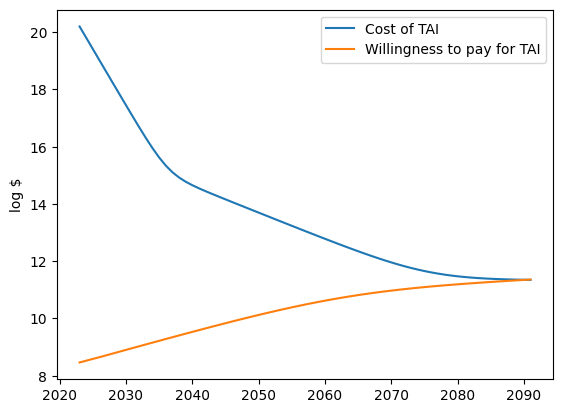

-
-
## SAMPLE RUN 26 ##
It takes 35.2 log FLOP (~158 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 9.6 log 2022$USD (~4 billion). This doubles every 1.9 years to a max of 0.446552% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.9 max log FLOP (7 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.9 to buy TAI (80 quadrillion) vs. willingness to pay log $ 9.6 (4 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.1 max log FLOP (13 octillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 16.6 to buy TAI (40 quadrillion) vs. willingness to pay log $ 9.7 (5 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP

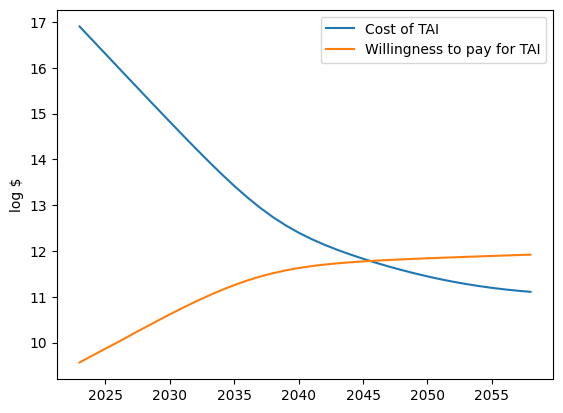

-
-
## SAMPLE RUN 27 ##
It takes 42.6 log FLOP (~4 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 4.1 years to a max of 0.06586% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 42.6 log FLOP (4 billion decillion) - log $ 24.3 to buy TAI (2 septillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (229 septillion) available - TAI takes 42.3 log FLOP (2 billion decillion) - log $ 23.9 to buy TAI (811 sextillion) vs. willingness to pay log $ 8.0 (93 million) - 18.4 log FLOP per $ (2 quintillion) 

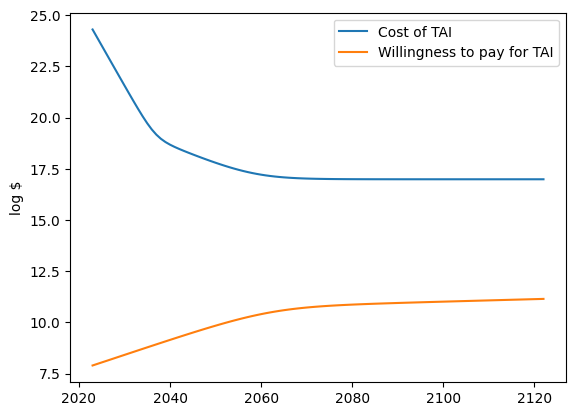

-
-
## SAMPLE RUN 28 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~765 million). This doubles every 3.9 years to a max of 0.089422% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 8.9 (737 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (61 quadrillion) vs. willingness to pay log $ 8.9 (876 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-lo

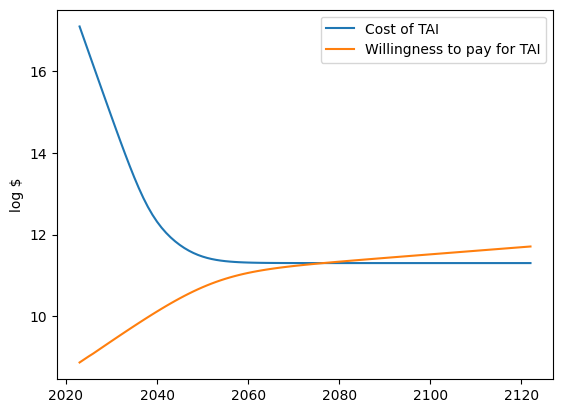

-
-
## SAMPLE RUN 29 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 33.9 log FLOP (7 decillion) - log $ 15.4 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.5 (344 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

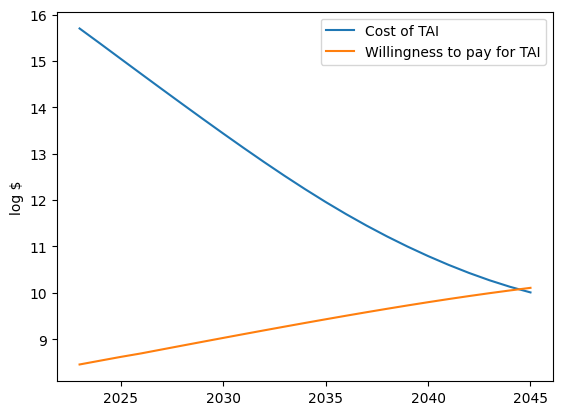

-
-
## SAMPLE RUN 30 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 5.2 years to a max of 0.081858% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.5 max log FLOP (311 septillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.2 (156 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (467 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (15 billion) vs. willingness to pay log $ 8.3 (178 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

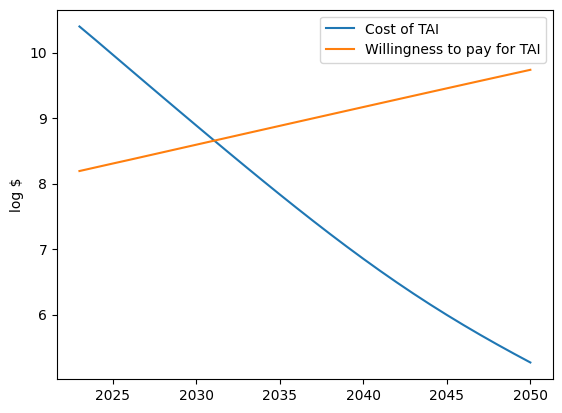

-
-
## SAMPLE RUN 31 ##
It takes 41.5 log FLOP (~316 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 2.7 years to a max of 0.036744% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.4 max log FLOP (244 septillion) available - TAI takes 41.5 log FLOP (316 million decillion) - log $ 23.2 to buy TAI (159 sextillion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (396 septillion) available - TAI takes 41.2 log FLOP (158 million decillion) - log $ 22.8 to buy TAI (63 sextillion) vs. willingness to pay log $ 8.2 (157 million) - 18.4 log FLOP per $ (3 quin

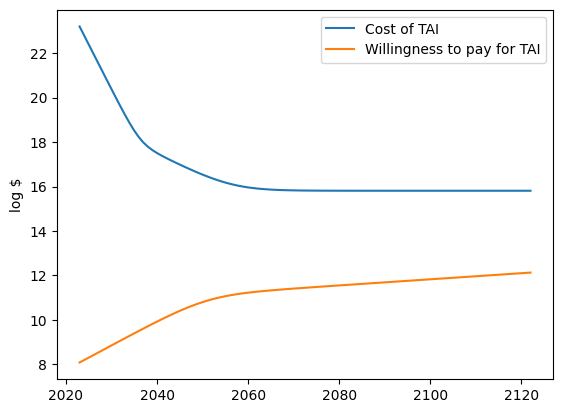

-
-
## SAMPLE RUN 32 ##
It takes 44.8 log FLOP (~631 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~310 million). This doubles every 2.8 years to a max of 0.069994% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (607 septillion) available - TAI takes 44.8 log FLOP (631 billion decillion) - log $ 26.5 to buy TAI (316 septillion) vs. willingness to pay log $ 8.5 (304 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (987 septillion) available - TAI takes 44.5 log FLOP (315 billion decillion) - log $ 26.1 to buy TAI (124 septillion) vs. willingness to pay log $ 8.6 (387 million) - 18.4 log FLOP per $ (3 qui

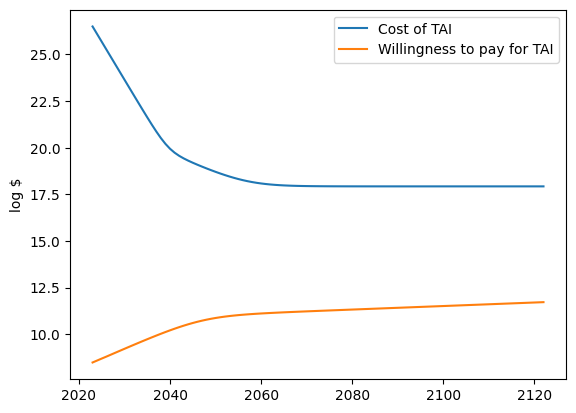

-
-
## SAMPLE RUN 33 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 3.5 years to a max of 0.182018% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.8 max log FLOP (621 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.5 (312 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (965 septillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.6 (380 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

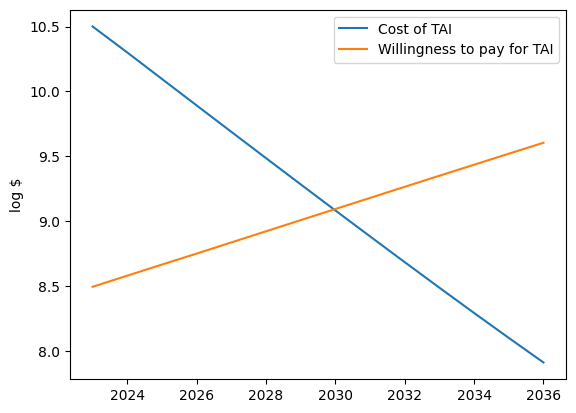

-
-
## SAMPLE RUN 34 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~71 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 3.7 years to a max of 0.02946% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.3 max log FLOP (194 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (794 million) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (284 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (523 million) vs. willingness to pay log $ 8.1 (117 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)

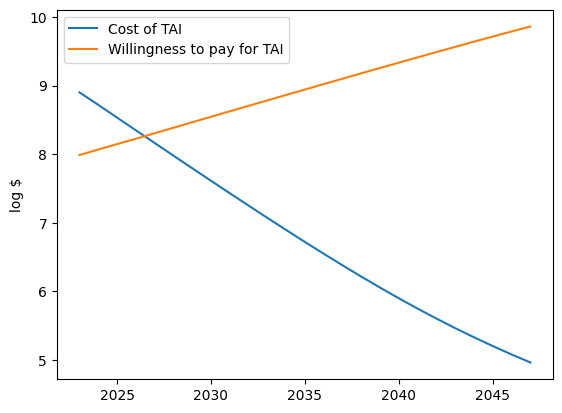

-
-
## SAMPLE RUN 35 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 2.6 years to a max of 0.067205% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2

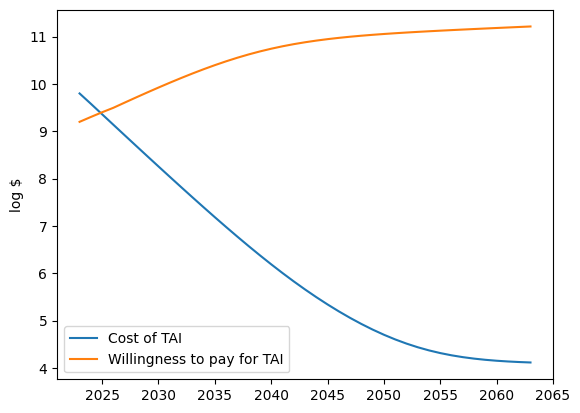

-
-
## SAMPLE RUN 36 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.8 years to a max of 0.027051% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (337 septillion) available - TAI takes 33.9 log FLOP (7 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.1 (124 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logF

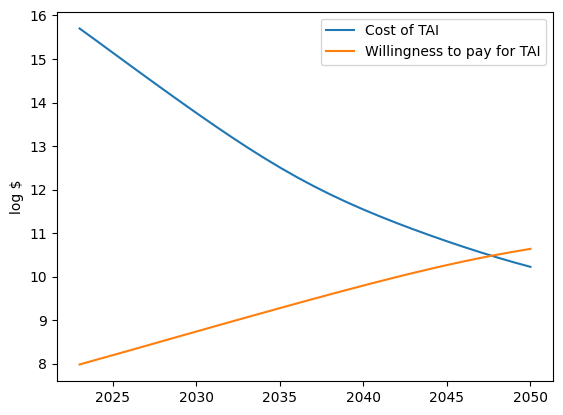

-
-
## SAMPLE RUN 37 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2025 - 2

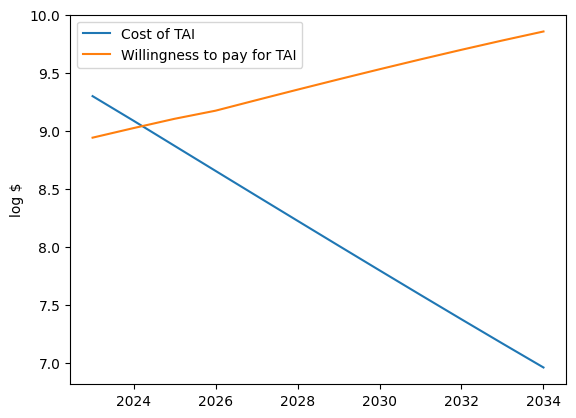

-
-
## SAMPLE RUN 38 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~741 million). This doubles every 2.2 years to a max of 0.047677% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.8 (694 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 9.0 (929 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.

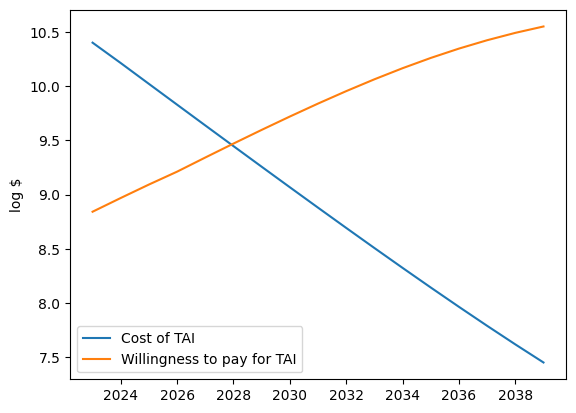

-
-
## SAMPLE RUN 39 ##
It takes 26.3 log FLOP (~200 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~373 million). This doubles every 3.2 years to a max of 0.025607% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.8 max log FLOP (700 septillion) available - TAI takes 26.3 log FLOP (200 septillion) - log $ 8.0 to buy TAI (100 million) vs. willingness to pay log $ 8.5 (351 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.6 -> Nonscaling delay

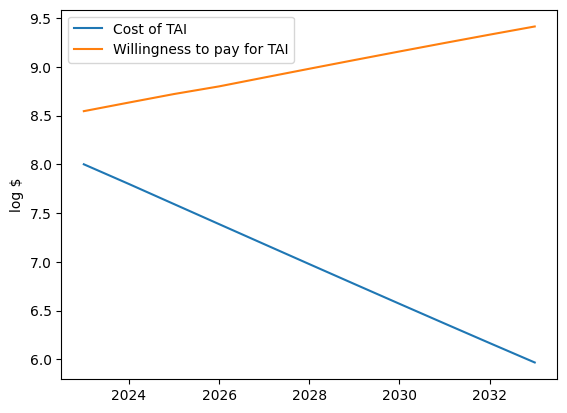

-
-
## SAMPLE RUN 40 ##
It takes 34.7 log FLOP (~50 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.3 years to a max of 0.062607% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.4 to buy TAI (25 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (264 septillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 16.1 to buy TAI (13 quadrillion) vs. willingness to pay log $ 8.0 (107 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-l

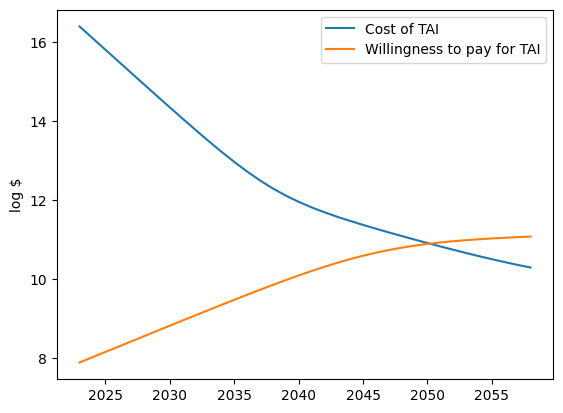

-
-
## SAMPLE RUN 41 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~311 million). This doubles every 1.4 years to a max of 0.087362% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.8 max log FLOP (612 septillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.5 (307 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (14 billion) vs. willingness to pay log $ 8.7 (494 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

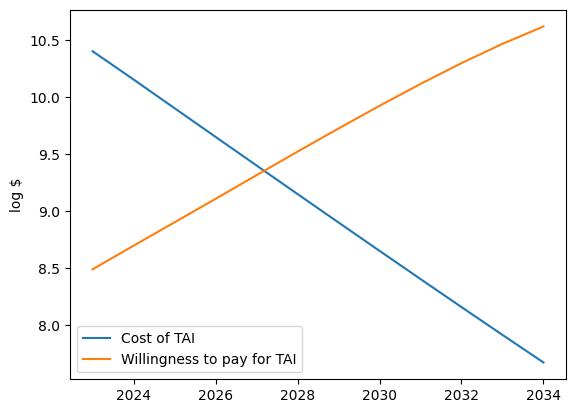

-
-
## SAMPLE RUN 42 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~172 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 2.6 years to a max of 0.074981% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (418 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.2 (161 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7)

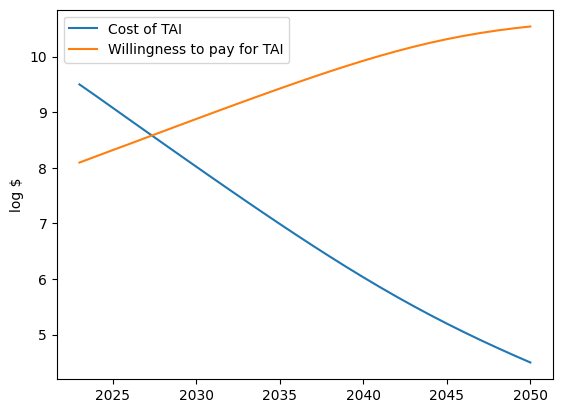

-
-
## SAMPLE RUN 43 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~54 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~494 million). This doubles every 3.6 years to a max of 0.15356% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.0 max log FLOP (972 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.7 (487 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.8 (589 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
Year

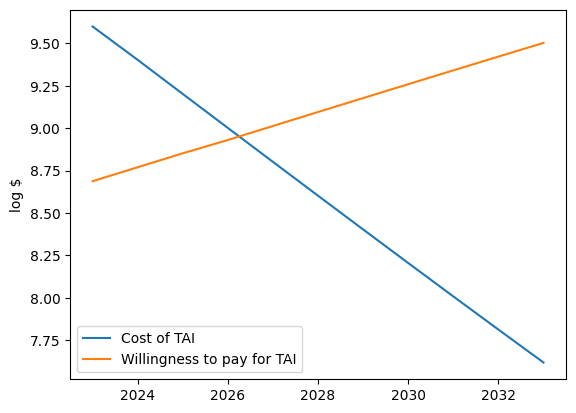

-
-
## SAMPLE RUN 44 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~29 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (668 billion) vs. willingness to pay log $ 8.6 (388 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)

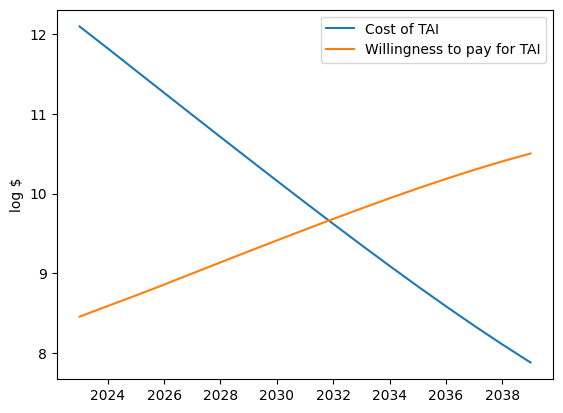

-
-
## SAMPLE RUN 45 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~76 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.7 to buy TAI (6 billion) vs. willingness to pay log $ 8.6 (441 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)

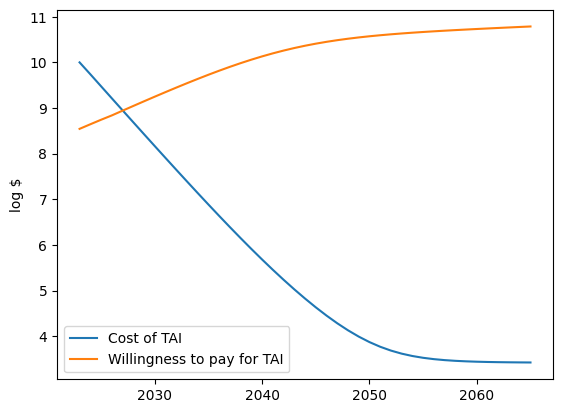

-
-
## SAMPLE RUN 46 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.2 to buy TAI (159 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (469 septillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.0 to buy TAI (98 billion) vs. willingness to pay log $ 8.3 (181 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFL

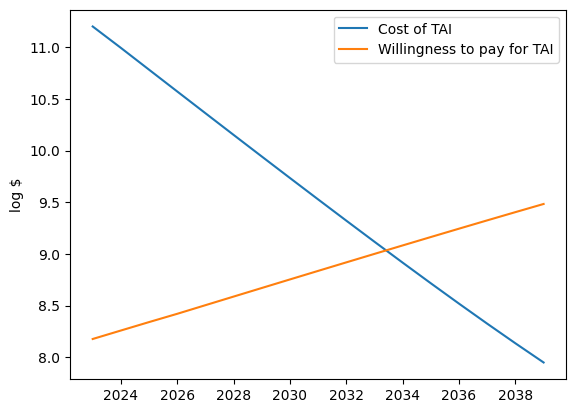

-
-
## SAMPLE RUN 47 ##
It takes 34.9 log FLOP (~79 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~79 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 4.4 years to a max of 0.128072% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.7 max log FLOP (493 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.6 to buy TAI (40 quadrillion) vs. willingness to pay log $ 8.4 (247 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (738 septillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.5 (288 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 202

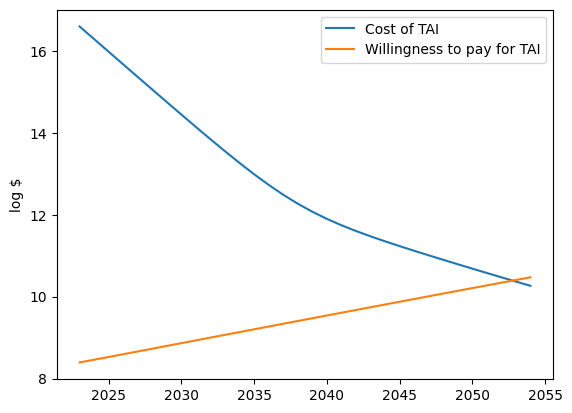

-
-
## SAMPLE RUN 48 ##
It takes 41.9 log FLOP (~794 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~91 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~373 million). This doubles every 3.7 years to a max of 0.025821% of GDP. GDP grows at a rate of 1.037x per year.
---
Year: 2023 - 26.8 max log FLOP (700 septillion) available - TAI takes 41.9 log FLOP (794 million decillion) - log $ 23.6 to buy TAI (398 sextillion) vs. willingness to pay log $ 8.5 (351 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 41.6 log FLOP (397 million decillion) - log $ 23.2 to buy TAI (154 sextillion) vs. willingness to pay log $ 8.6 (420 million) - 18.4 log FLOP per $ (3 quint

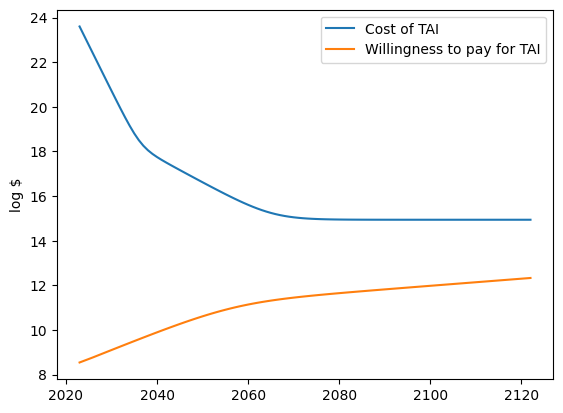

-
-
## SAMPLE RUN 49 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~862 million). This doubles every 1 years to a max of 0.027137% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 8.9 (757 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (60 quadrillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logF

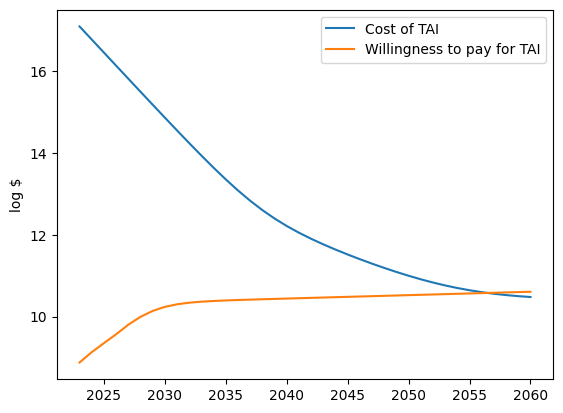

-
-
## SAMPLE RUN 50 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.7 years to a max of 0.070329% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP (292 septillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.3 to buy TAI (223 million) vs. willingness to pay log $ 8.0 (102 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logF

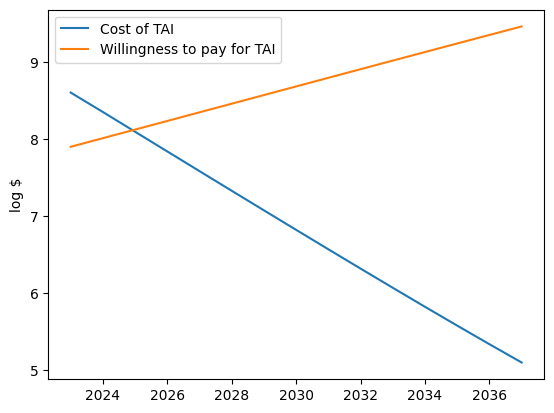

-
-
## SAMPLE RUN 51 ##
It takes 35.9 log FLOP (~794 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.6 to buy TAI (398 quadrillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.3 to buy TAI (212 quadrillion) vs. willingness to pay log $ 8.9 (772 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-lo

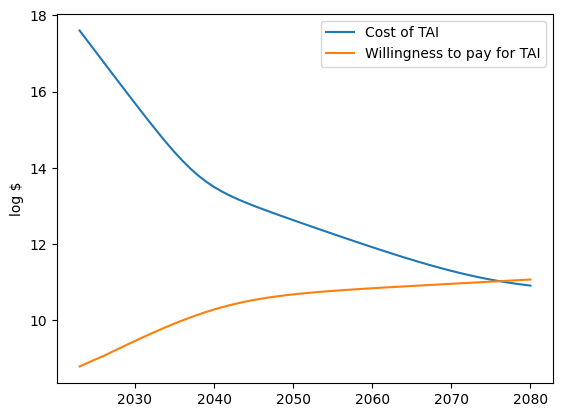

-
-
## SAMPLE RUN 52 ##
It takes 31.1 log FLOP (~13 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~378 million). This doubles every 3.0 years to a max of 0.031936% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP (717 septillion) available - TAI takes 31.1 log FLOP (13 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.6 (359 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.7 (449 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

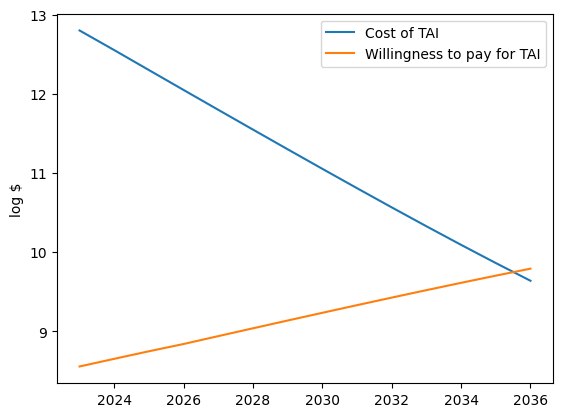

-
-
## SAMPLE RUN 53 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.8 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 2.8 years to a max of 0.223567% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (623 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.5 (312 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.6 (398 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-

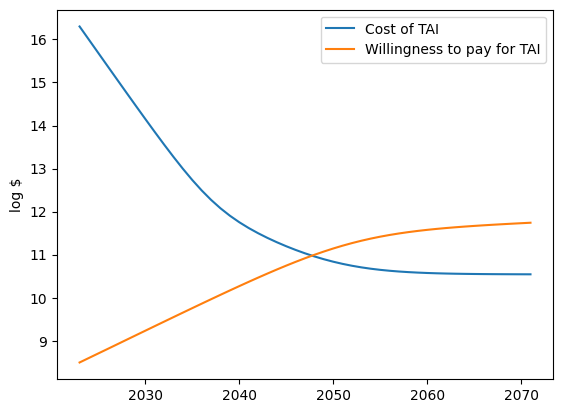

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)